In [29]:
import sympy as sp
import numpy as np

# Task 1

Derive dynamic model for your robot model using the Euler-Lagrange approach

In [30]:
from collections import namedtuple

Angles = namedtuple('Angles', ['theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6'])

Configuration = namedtuple('Configuration', ['d_1', 'd_2', 'd_3', 'd_4', 'd_5'])
general_configuration = Configuration(*[sp.Symbol(f'd_{i}') for i in range(1, 6)])

t = sp.Symbol('t')
general_angles = Angles(*[sp.Function(f'q_{i}')(t) for i in range(1, 7)])


def get_dh_parameters(angles: Angles):
    dh_parameters = [
        # a                         d                                                       alpha       theta
        (0,                         general_configuration.d_1,                              sp.pi / 2,  angles.theta_1),
        (general_configuration.d_2, 0,                                                      0,          angles.theta_2),
        (0,                         0,                                                      -sp.pi / 2, angles.theta_3 - sp.pi / 2),
        (0,                         general_configuration.d_3 + general_configuration.d_4,  sp.pi / 2,  angles.theta_4 - sp.pi / 2),
        (0,                         0,                                                      -sp.pi / 2, angles.theta_5),
        (0,                         general_configuration.d_5,                              0,          angles.theta_6)
    ]
    return dh_parameters


In [31]:
class Rotation:
    @staticmethod
    def around_z(_theta):
        return sp.Matrix([[sp.cos(_theta),  -sp.sin(_theta),    0,  0],
                          [sp.sin(_theta),  sp.cos(_theta),     0,  0],
                          [0,                0,                 1,  0],
                          [0,               0,                  0,  1]])
    
    @staticmethod
    def around_x(_theta):
        return sp.Matrix([[1,   0,              0,                  0],
                          [0,   sp.cos(_theta), -sp.sin(_theta),    0],
                          [0,   sp.sin(_theta), sp.cos(_theta),     0],
                          [0,   0,              0,                  1]])


class Translation:
    @staticmethod
    def on_z(distance):
        return sp.Matrix([[1, 0, 0, 0],
                          [0, 1, 0, 0],
                          [0, 0, 1, distance],
                          [0, 0, 0, 1]])
    
    @staticmethod
    def on_x(distance):
        return sp.Matrix([[1, 0, 0, distance],
                          [0, 1, 0, 0],
                          [0, 0, 1, 0],
                          [0, 0, 0, 1]])

In [32]:
from operator import mul
from functools import reduce


def dh_transform(a, d, alpha, theta):
    rotation_theta = Rotation.around_z(theta)
    translation_d = Translation.on_z(d)
    translation_a = Translation.on_x(a)
    rotation_alpha = Rotation.around_x(alpha)

    return reduce(mul, [rotation_theta, translation_d, translation_a, rotation_alpha])

In [33]:
from itertools import starmap, accumulate


def forward_kinematics(angles: Angles):
    transforms = starmap(dh_transform, get_dh_parameters(angles))

    base_frame = sp.eye(4)
    frames_history = list(accumulate(transforms, func=mul, initial=base_frame))

    return frames_history

In [34]:
frames = forward_kinematics(general_angles)

In [35]:
com_dh = [
    [0, general_configuration.d_1 / 3, 0, general_angles.theta_1],
    [general_configuration.d_2 / 3, 0, 0, general_angles.theta_2],
    [general_configuration.d_3 / 3, 0, 0, general_angles.theta_3],
    [0, general_configuration.d_3 + general_configuration.d_4 / 3, 0, general_angles.theta_4],
    [0, general_configuration.d_5 / 3, 0, general_angles.theta_6]
]

com_frames = [frame * dh_transform(*dh) for frame, dh in zip(frames, com_dh)]

In [36]:
inertia_tensors = [sp.Matrix([[sp.Symbol(f'I_{{{first}{second}_{i}}}') for second in ('x', 'y', 'z')] for first in ('x', 'y', 'z')]) for i in range(1, len(com_frames))]
inertia_tensors = [tensor.replace(tensor[1, 0], tensor[0, 1]).replace(tensor[2, 0], tensor[0, 2]).replace(tensor[2, 1], tensor[1, 2]) for tensor in inertia_tensors]

In [37]:
link_masses = [sp.Symbol(f'm_{i}') for i in range(1, len(com_frames) + 1)]

In [38]:
linear_jacobians = []
for frame in com_frames:
    jacobian = sp.zeros(3, len(com_frames))

    for i, q in enumerate(general_angles[:len(com_frames)]):
        jacobian[:, i] = frame[:3, 3].diff(q)

    jacobian.simplify()

    linear_jacobians.append(jacobian)


In [39]:
angular_jacobians = []
for frame in com_frames:
    jacobian = sp.zeros(3, len(com_frames))

    for i, q in enumerate(general_angles[:len(com_frames)]):
        jacobian[:, i] = frame[:3, 2].diff(q)
    
    jacobian.simplify()

    angular_jacobians.append(jacobian)

In [40]:
inertial_matrix = sp.zeros(len(com_frames))

for i, (mass, inertia, linear_jacobian, angular_jacobian, frame) in enumerate(zip(link_masses, inertia_tensors, linear_jacobians, angular_jacobians, com_frames)):
    inertial_matrix += mass * linear_jacobian.T * linear_jacobian
    inertial_matrix += angular_jacobian.T * frame[:3, :3] * inertia * frame[:3, :3].T * angular_jacobian

inertial_matrix.simplify()

In [41]:
inertial_matrix.is_symmetric()

True

In [42]:
from itertools import product

coriolis = sp.zeros(len(com_frames))

for i, j in product(range(len(com_frames)), range(len(com_frames))):
    for k in range(len(com_frames)):
        q_dot = general_angles[k].diff(t)
        c_ijk = 0.5 * (inertial_matrix[i, j].diff(general_angles[k]) + inertial_matrix[i, k].diff(general_angles[j]) - inertial_matrix[j, k].diff(general_angles[i]))
        coriolis[i, j] += c_ijk * q_dot

In [44]:
from functools import reduce
from operator import add

acceleration = sp.Matrix([0, 0, -9.80665])

gravity_vector = reduce(add, [mass * jacobian.T * acceleration for mass, jacobian in zip(link_masses, linear_jacobians)])

In [45]:
# given in grams * square millimeters
inertia_tensors_values = np.array([[[127315.49, 0.0, 0.0],
                                    [0.0, 17300.01, 0.0], 
                                    [0.0, 0.0, 127315.49]]] * len(com_frames))
inertia_tensors_values *= 1e-9 

# given in grams
link_masses_values = np.array([111.83] * len(com_frames))
link_masses_values *= 1e-3

In [46]:
configuration = Configuration(1., 3., 2., 1., 1.)

In [47]:
# substituting values for inertia tensors
for general_inertia_tensor, inertia_tensor_values in zip(inertia_tensors, inertia_tensors_values):
    for i, j in product(range(general_inertia_tensor.shape[0]), range(general_inertia_tensor.shape[1])):
        inertial_matrix = inertial_matrix.subs(general_inertia_tensor[i, j], inertia_tensor_values[i, j])
        coriolis = coriolis.subs(general_inertia_tensor[i, j], inertia_tensor_values[i, j])

In [48]:
# substituting values for masses
for general_mass, mass_value in zip(link_masses, link_masses_values):
    inertial_matrix = inertial_matrix.subs(general_mass, mass_value)
    coriolis = coriolis.subs(general_mass, mass_value)
    gravity_vector = gravity_vector.subs(general_mass, mass_value)

In [49]:
# substituting values for links lengths
for general_length, length_value in zip(general_configuration, configuration):
    inertial_matrix = inertial_matrix.subs(general_length, length_value)
    coriolis = coriolis.subs(general_length, length_value)
    gravity_vector = gravity_vector.subs(general_length, length_value)

In [61]:
angular_velocities = [q.diff(t) for q in general_angles[:-1]]

In [62]:
get_inertial_matrix = sp.lambdify(general_angles[:-1], inertial_matrix, 'numpy')
get_coriolis_matrix = sp.lambdify([*general_angles[:-1], *angular_velocities], coriolis, 'numpy')
get_gravity_vector = sp.lambdify(general_angles[:-1], gravity_vector, 'numpy')

# Task 2
Drive the robot joints between $[0,\pi]$

With zero velocity and acceleration (gravity torques)

In [131]:
def get_torques(angles: np.ndarray, velocities: np.ndarray, accelerations: np.ndarray) -> np.ndarray:
    _inertial_matrix = get_inertial_matrix(*angles)
    _coriolis_matrix = get_coriolis_matrix(*angles, *velocities)
    _gravity_vector = get_gravity_vector(*angles).flatten()

    return _inertial_matrix.dot(accelerations) + _coriolis_matrix.dot(velocities) + _gravity_vector

In [132]:
points = [np.linspace(0, np.pi, 200) for _ in range(len(general_angles[:-1]))]

torques_history = []

for current_position in zip(*points):
    torques_history.append(get_torques(np.array(current_position), np.zeros(len(general_angles[:-1])), np.zeros(len(general_angles[:-1]))))

torques_history = np.array(torques_history)

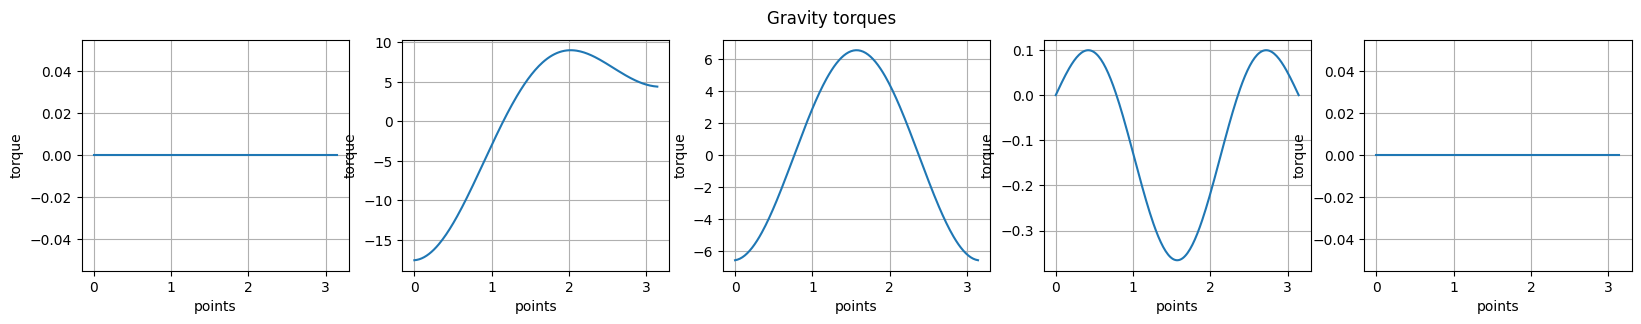

In [133]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 5, figsize=(20, 3))

figure.suptitle('Gravity torques')

for _points, axis, torque in zip(points, axes, torques_history.T):
    axis.plot(_points, torque)
    axis.set_xlabel('points')
    axis.set_ylabel('torque')
    axis.grid(True)

plt.show()

Drive the robot using a trapezoidal profile

In [134]:
Constraints = namedtuple('Constraints', ['velocity', 'acceleration'])
constraints = Constraints(2, 3)

In [135]:
def sign(n: float) -> float:
    if n >= 0:
        return 1
    else:
        return -1

In [136]:
def trapezoidal_trajectory(blend_time: float, non_acceleration_time: float, initial_value: float, final_value: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    _sign = sign(final_value - initial_value)

    first_stage_distance = initial_value + _sign * constraints.acceleration * blend_time ** 2 / 2
    second_stage_distance = first_stage_distance + _sign * constraints.velocity * non_acceleration_time
    timeline = np.linspace(0, blend_time * 2 + non_acceleration_time, 200)

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: initial_value + _sign * constraints.acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + _sign * constraints.velocity * (t - blend_time),
                  lambda t: second_stage_distance + _sign * constraints.velocity * (t - blend_time - non_acceleration_time) - _sign * constraints.acceleration * (t - blend_time - non_acceleration_time) ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: _sign * constraints.acceleration * t,
                  lambda t: _sign * constraints.velocity,
                  lambda t: _sign * constraints.velocity - _sign * constraints.acceleration * (t - blend_time - non_acceleration_time)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  np.logical_and(blend_time < timeline, timeline <= blend_time + non_acceleration_time),
                  blend_time + non_acceleration_time < timeline],
        funclist=[lambda t: _sign * constraints.acceleration,
                  lambda t: 0,
                  lambda t: _sign * -constraints.acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [137]:
def triangular_trajectory(initial_value: float, final_value: float):
    _sign = sign(final_value - initial_value)

    blend_time = np.sqrt(abs(final_value - initial_value) / constraints.acceleration)
    timeline = np.linspace(0, blend_time * 2, 200)

    first_stage_distance = initial_value + _sign * constraints.acceleration * blend_time ** 2 / 2

    trajectory_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: initial_value + _sign * constraints.acceleration * t ** 2 / 2,
                  lambda t: first_stage_distance + _sign * constraints.acceleration * blend_time * (t - blend_time) - _sign * constraints.acceleration * (t - blend_time) ** 2 / 2]
    )

    velocity_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: _sign * constraints.acceleration * t,
                  lambda t: _sign * constraints.acceleration * blend_time - _sign * constraints.acceleration * (t - blend_time)]
    )

    acceleration_points = np.piecewise(
        x=timeline,
        condlist=[timeline <= blend_time,
                  timeline > blend_time],
        funclist=[lambda t: _sign * constraints.acceleration,
                  lambda t: _sign * -constraints.acceleration]
    )

    return timeline, trajectory_points, velocity_points, acceleration_points

In [138]:
trajectories = []
velocities = []
accelerations = []
timelines = []

initial_position = Angles(*([0] * 6))
final_position = Angles(*([np.pi] * 6))

for initial, final in zip(initial_position, final_position):
    delta_distance = abs(final - initial)

    blend_time = constraints.velocity / constraints.acceleration
    acceleration_distance = constraints.velocity ** 2 / constraints.acceleration

    non_acceleration_distance = delta_distance - acceleration_distance
    non_acceleration_time = non_acceleration_distance / constraints.velocity

    if non_acceleration_time < 0:
        timeline, trajectory, velocity, acceleration = triangular_trajectory(initial, final)
    else:
        timeline, trajectory, velocity, acceleration = trapezoidal_trajectory(blend_time, non_acceleration_time, initial, final)
    timelines.append(timeline)
    trajectories.append(trajectory)
    velocities.append(velocity)
    accelerations.append(acceleration)

In [139]:
torques_history = []

for i in range(len(trajectories[0])):
    current_positions = np.array([trajectories[j][i] for j in range(len(trajectories) - 1)])
    current_velocities = np.array([velocities[j][i] for j in range(len(velocities) - 1)])
    current_accelerations = np.array([accelerations[j][i] for j in range(len(accelerations) - 1)])
    torques_history.append(get_torques(current_positions, current_velocities, current_accelerations))

torques_history = np.array(torques_history)

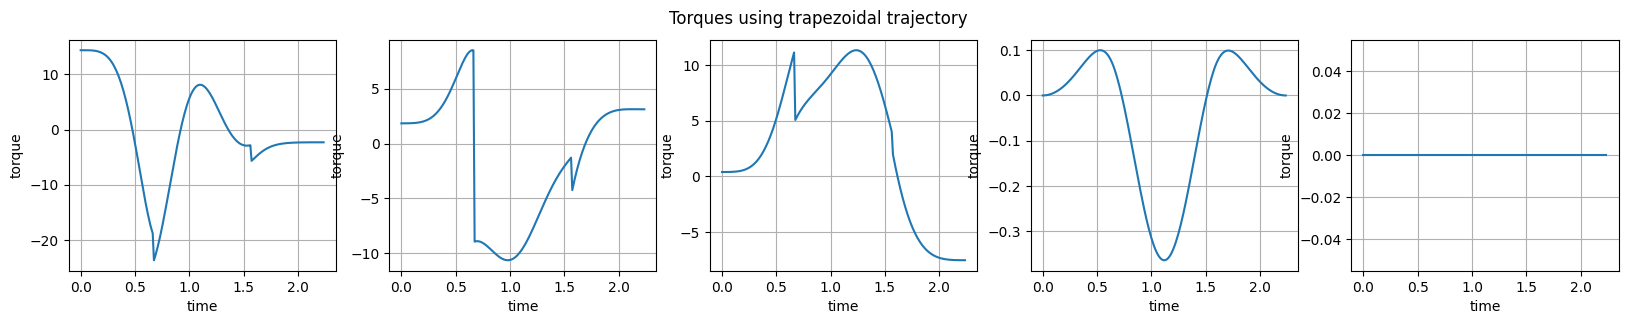

In [140]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 5, figsize=(20, 3))

figure.suptitle('Torques using trapezoidal trajectory')

for timeline, axis, torque in zip(timelines, axes, torques_history.T):
    axis.plot(timeline, torque)
    axis.set_xlabel('time')
    axis.set_ylabel('torque')
    axis.grid(True)

plt.show()

Drive the robot using a polynomial profile

In [141]:
Conditions = namedtuple('Conditions', ['time', 'position', 'velocity', 'acceleration'])

In [142]:
def construct_quintic_polynom_matrix(initial_time: float, final_time: float) -> np.ndarray:
    t_0, t_f = initial_time, final_time
    return np.array([[t_0 ** 5,         t_0 ** 4,       t_0 ** 3,       t_0 ** 2,   t_0,    1],
                     [t_f ** 5,         t_f ** 4,       t_f ** 3,       t_f ** 2,   t_f,    1],
                     [5 * t_0 ** 4,     4 * t_0 ** 3,   3 * t_0 ** 2,   2 * t_0,    1,      0],
                     [5 * t_f ** 4,     4 * t_f ** 3,   3 * t_f ** 2,   2 * t_f,    1,      0],
                     [20 * t_0 ** 3,    12 * t_0 ** 2,  6 * t_0,        2,          0,      0],
                     [20 * t_f ** 3,    12 * t_f ** 2,  6 * t_f,        2,          0,      0]])

In [143]:
from itertools import chain


def find_polynom_coefficients(initial_conditions: Conditions, final_conditions: Conditions) -> np.ndarray:
    matrix = construct_quintic_polynom_matrix(initial_conditions.time, final_conditions.time)
    column = np.array(list(chain.from_iterable([[x for x in initial_final] for initial_final in zip(initial_conditions[1:], final_conditions[1:])])))

    return np.linalg.solve(matrix, column)


In [144]:
def get_position(coefficients: np.ndarray, time: float) -> float:
    time_vector = np.array([time ** (5 - i) for i in range(6)])
    return coefficients.dot(time_vector)


def get_velocity(coefficients: np.ndarray, time: float) -> float:
    time_vector = np.array([5 * time ** 4, 4 * time ** 3, 3 * time ** 2, 2 * time, 1, 0])
    return coefficients.dot(time_vector)


def get_acceleration(coefficients: np.ndarray, time: float) -> float:
    time_vector = np.array([20 * time ** 3, 12 * time ** 2, 6 * time, 2, 0, 0])
    return coefficients.dot(time_vector)

In [145]:
initial_states = [Conditions(0, 0, 0, 0) for _ in range(6)]
final_states = [Conditions(10, np.pi, 0, 0) for _ in range(6)]

coefficients_list = [find_polynom_coefficients(initial_state, final_state) for initial_state, final_state in zip(initial_states, final_states)]

In [146]:
timeline = np.linspace(0, 10, 200)

positions = []
velocities = []
accelerations = []

for coefficients in coefficients_list:
    positions.append(np.array([get_position(coefficients, t) for t in timeline]))
    velocities.append(np.array([get_velocity(coefficients, t) for t in timeline]))
    accelerations.append(np.array([get_acceleration(coefficients, t) for t in timeline]))

In [147]:
torques_history = []

for i in range(len(positions[0])):
    current_positions = np.array([positions[j][i] for j in range(len(positions) - 1)])
    current_velocities = np.array([velocities[j][i] for j in range(len(velocities) - 1)])
    current_accelerations = np.array([accelerations[j][i] for j in range(len(accelerations) - 1)])
    torques_history.append(get_torques(current_positions, current_velocities, current_accelerations))

torques_history = np.array(torques_history)

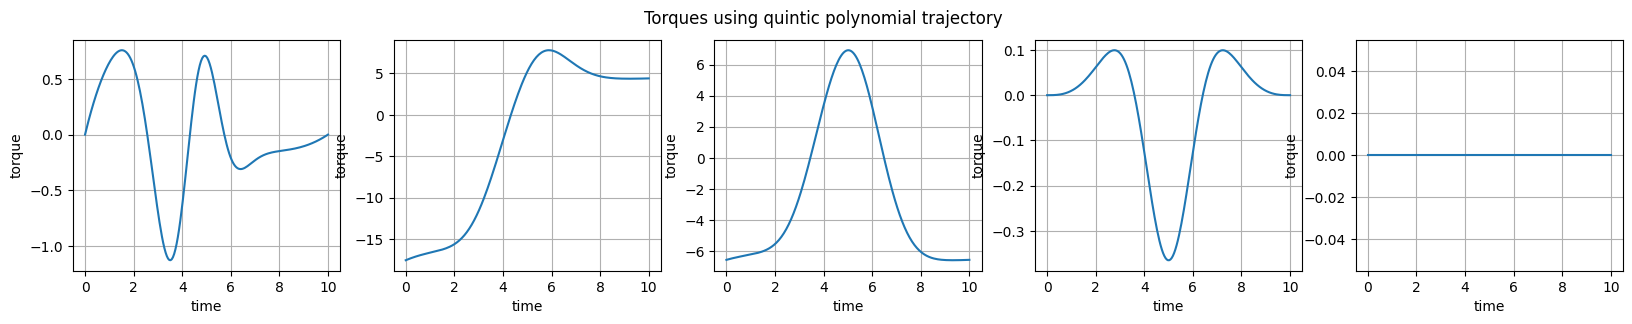

In [148]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 5, figsize=(20, 3))

figure.suptitle('Torques using quintic polynomial trajectory')

for axis, torque in zip(axes, torques_history.T):
    axis.plot(timeline, torque)
    axis.set_xlabel('time')
    axis.set_ylabel('torque')
    axis.grid(True)

plt.show()